<a href="https://colab.research.google.com/github/PratikshitSingh/Algotrading/blob/master/stock_prediction_using_LSTM_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
datadir = "/content/drive/My Drive/Quant"
os.chdir(datadir)
!pwd

/content/drive/My Drive/Quant


In [3]:
#!unzip "preprocessed_CAC40.csv"

Archive:  preprocessed_CAC40.csv.zip
  inflating: preprocessed_CAC40.csv  


In [4]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
# Load csv
# This is preprocessed data created using the close price and volume traded
df = pd.read_csv('preprocessed_CAC40.csv', parse_dates=['Date'])

In [15]:
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [14]:
df['Name'].unique()

array(['Accor', 'Air Liquide', 'Airbus ', 'ArcelorMittal', 'Atos', 'AXA',
       'BNP Paribas', 'Bouygues', 'Cap Gemini', 'Crédit Agricole',
       'Danone', 'Dassault Systèmes', 'Engie (ex GDF Suez',
       'EssilorLuxottica', 'Hermès (Hermes International', 'Kering',
       'LEGRAND', 'LOréal', 'LVMH Moet Hennessy Louis Vuitton',
       'Michelin (Compagnie Générale d Etablissements Michelin SCPA',
       'Orange', 'Pernod Ricard', 'Peugeot', 'Publicis', 'Renault',
       'SAFRAN', 'Saint-Gobain', 'Sanofi', 'Schneider Electric',
       'Société Générale (Societe Generale', 'Sodexo',
       'STMicroelectronics', 'TOTAL', 'Unibail-Rodamco',
       'Veolia Environnement', 'VINCI', 'Vivendi', 'Worldline SA'],
      dtype=object)

In [11]:
def load_data(company, start, end):
    """
    Load data for the specified company and date range.

    :param company: The company's stock symbol (str)
    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [12]:
COMPANY = 'Accor'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

In [16]:
# Filter only data for Accor
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [29]:
# Range of close price
data['Close'].max() - data['Close'].min()

20.03

In [30]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

sacled_data is just the array of data['close'] using the minmax transformation

In [36]:
# Range of close price after normalization
scaled_data.max() - scaled_data.min()

0.9999999999999998

In [37]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [43]:
x_train.shape

(1202, 60, 1)

In [44]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [45]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [46]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.0409

38/38 [==============================] - 12s 99ms/step - loss: 0.0409
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.0117

38/38 [==============================] - 4s 100ms/step - loss: 0.0117
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.0105

38/38 [==============================] - 5s 135ms/step - loss: 0.0105
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.0100

38/38 [==============================] - 6s 145ms/step - loss: 0.0100
Epoch 5/25
38/38 [==============================] - ETA: 0s - loss: 0.0090

38/38 [==============================] - 4s 97ms/step - loss: 0.0090
Epoch 6/25
38/38 [==============================] - ETA: 0s - loss: 0.0083

38/38 [==============================] - 5s 119ms/step - loss: 0.0083
Epoch 7/25
38/38 [==============================] - ETA: 0s - loss: 0.0079

38/38 [==============================] - 5s 133ms/step - loss: 0.0079
Epoch 8/25
38/38 [==============================] - ETA: 0s - loss: 0.0074

38/38 [==============================] - 4s 100ms/step - loss: 0.0074
Epoch 9/25
38/38 [==============================] - ETA: 0s - loss: 0.0083

38/38 [==============================] - 8s 211ms/step - loss: 0.0083
Epoch 10/25
38/38 [==============================] - ETA: 0s - loss: 0.0067

38/38 [==============================] - 4s 117ms/step - loss: 0.0067
Epoch 11/25
38/38 [==============================] - ETA: 0s - loss: 0.0068

38/38 [==============================] - 4s 107ms/step - loss: 0.0068
Epoch 12/25
38/38 [==============================] - ETA: 0s - loss: 0.0069

38/38 [==============================] - 5s 121ms/step - loss: 0.0069
Epoch 13/25
38/38 [==============================] - ETA: 0s - loss: 0.0062

38/38 [==============================] - 5s 133ms/step - loss: 0.0062
Epoch 14/25
38/38 [==============================] - ETA: 0s - loss: 0.0060

38/38 [==============================] - 4s 102ms/step - loss: 0.0060
Epoch 15/25
38/38 [==============================] - ETA: 0s - loss: 0.0062

38/38 [==============================] - 4s 105ms/step - loss: 0.0062
Epoch 16/25
38/38 [==============================] - ETA: 0s - loss: 0.0061

38/38 [==============================] - 6s 150ms/step - loss: 0.0061
Epoch 17/25
38/38 [==============================] - ETA: 0s - loss: 0.0056

38/38 [==============================] - 4s 100ms/step - loss: 0.0056
Epoch 18/25
38/38 [==============================] - ETA: 0s - loss: 0.0058

38/38 [==============================] - 4s 103ms/step - loss: 0.0058
Epoch 19/25
38/38 [==============================] - ETA: 0s - loss: 0.0051

38/38 [==============================] - 6s 157ms/step - loss: 0.0051
Epoch 20/25
38/38 [==============================] - ETA: 0s - loss: 0.0054

38/38 [==============================] - 4s 101ms/step - loss: 0.0054
Epoch 21/25
38/38 [==============================] - ETA: 0s - loss: 0.0051

38/38 [==============================] - 4s 104ms/step - loss: 0.0051
Epoch 22/25
38/38 [==============================] - ETA: 0s - loss: 0.0054

38/38 [==============================] - 5s 128ms/step - loss: 0.0054
Epoch 23/25
38/38 [==============================] - ETA: 0s - loss: 0.0045

38/38 [==============================] - 5s 121ms/step - loss: 0.0045
Epoch 24/25
38/38 [==============================] - ETA: 0s - loss: 0.0049

38/38 [==============================] - 4s 96ms/step - loss: 0.0049
Epoch 25/25
38/38 [==============================] - ETA: 0s - loss: 0.0050

38/38 [==============================] - 4s 100ms/step - loss: 0.0050


In [47]:
# Load test data for the specified company and date range
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [48]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 [==============================] - 2s 24ms/step


## Test Data plotting

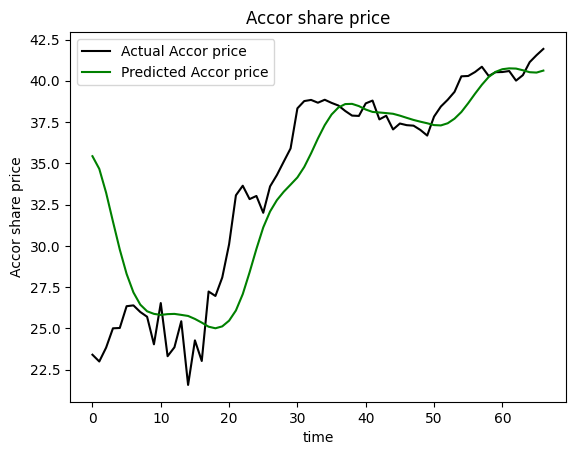

In [49]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [50]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 3s 3s/step
Prediction: 40.874961853027344
